<a href="https://colab.research.google.com/github/chengjin-hub/2D-image-of-rock-sample-in-CT-/blob/main/3Dzhujiangqiepiantiqu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from datetime import datetime, timedelta
import io

# ==========================================
# 1. 加载数据 (如果是在本地运行，请修改 file_path)
# ==========================================
# 如果您在 Google Colab，请取消下面两行的注释来上传文件：
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]))

# 本地运行请使用:
# df = pd.read_csv('grouting_final.csv.xlsx - 表格数据 (2).csv')

# ==========================================
# 2. 数据清洗与预处理
# ==========================================
# 清洗列名 (去除空格)
df.columns = df.columns.str.strip()
# 建立列名映射，防止大小写或命名差异
col_map = {
    'Arrival_Time_s': 'Arrival_Time_s', 'Time': 'Arrival_Time_s', '时间': 'Arrival_Time_s',
    'X_cm': 'X_cm', 'X': 'X_cm', 'Y_cm': 'Y_cm', 'Y': 'Y_cm', 'Z_cm': 'Z_cm', 'Z': 'Z_cm'
}
df = df.rename(columns=lambda x: col_map.get(x, x))

# 时间格式解析函数
def parse_time(t):
    try:
        # 尝试标准格式 HH:MM:SS
        return pd.to_datetime(t, format='%H:%M:%S')
    except:
        # 尝试自动推断
        return pd.to_datetime(t, errors='coerce')

df['Timestamp'] = df['Arrival_Time_s'].apply(parse_time)
# 过滤无效数据
valid_df = df.dropna(subset=['Timestamp']).copy()

# 统一基准日期 (防止跨日问题，统一设为 1900-01-01)
base_date = valid_df['Timestamp'].iloc[0].date()
valid_df['Timestamp'] = valid_df['Timestamp'].apply(lambda dt: dt.replace(year=base_date.year, month=base_date.month, day=base_date.day))

# 设定参考零点 (用于计算秒数)
ref_time_str = "10:00:00" # 您指定的基准时间
ref_time = datetime.strptime(ref_time_str, "%H:%M:%S").replace(year=base_date.year, month=base_date.month, day=base_date.day)

# 计算每个点相对于 10:00:00 的秒数
valid_df['seconds_from_ref'] = (valid_df['Timestamp'] - ref_time).dt.total_seconds()

print(f"数据加载成功！有效数据点: {len(valid_df)}")
print("正在构建 3D 实体模型 (插值计算中)...")

# ==========================================
# 3. 空间插值 (构建 3D 浆液实体)
# ==========================================
# 网格精度设为 1.0cm (平衡精度与速度)
grid_step = 1.0
grid_x, grid_y, grid_z = np.mgrid[0:100:grid_step, 0:100:grid_step, 0:20:grid_step]

points = valid_df[['X_cm', 'Y_cm', 'Z_cm']].values
values = valid_df['seconds_from_ref'].values

# 线性插值
grid_times = griddata(points, values, (grid_x, grid_y, grid_z), method='linear')
# 边缘填充 (防止空缺)
mask = np.isnan(grid_times)
grid_times[mask] = griddata(points, values, (grid_x[mask], grid_y[mask], grid_z[mask]), method='nearest')

# 扁平化数据以便绘图和计算
flat_x = grid_x.flatten()
flat_y = grid_y.flatten()
flat_z = grid_z.flatten()
flat_t = grid_times.flatten()

# ==========================================
# 4. 时间切片与测量
# ==========================================
# 定义您需要的具体时刻
target_times_str = [
    "10:01:00", "10:02:00", "10:03:00", "10:04:00",
    "10:05:00", "10:06:00", "10:07:00", "10:08:00"
]

measurements = []

# 设置绘图画布 (2行4列)
fig = plt.figure(figsize=(20, 10))
plt.suptitle('3D Grout Diffusion Snapshots & Measurements', fontsize=16)

for i, t_str in enumerate(target_times_str):
    # 当前目标时间对象
    target_t = datetime.strptime(t_str, "%H:%M:%S").replace(year=base_date.year, month=base_date.month, day=base_date.day)
    # 目标时间对应的秒数
    target_seconds = (target_t - ref_time).total_seconds()

    # 核心逻辑：找出所有“到达时间 <= 当前时刻”的网格点
    # 这些点构成了当前的浆液实体
    wet_mask = flat_t <= target_seconds

    # 初始化测量数据
    diff_length = 0
    diff_width = 0
    diff_height = 0

    ax = fig.add_subplot(2, 4, i+1, projection='3d')

    if np.any(wet_mask):
        wet_x = flat_x[wet_mask]
        wet_y = flat_y[wet_mask]
        wet_z = flat_z[wet_mask]

        # --- 测量计算 ---
        # 1. 长向 (Length): 假设注浆口在 X=100，向 X=0 扩散
        # 扩散距离 = 100 - X轴最小坐标
        min_x = np.min(wet_x)
        diff_length = 100.0 - min_x

        # 2. 宽向 (Width): Y轴覆盖的总宽度
        min_y, max_y = np.min(wet_y), np.max(wet_y)
        diff_width = max_y - min_y

        # 3. 高向 (Height): Z轴爬升的最大高度
        max_z = np.max(wet_z)
        diff_height = max_z

        # --- 3D 绘图 ---
        # 绘制浆液粒子
        ax.scatter(wet_x, wet_y, wet_z, c='blue', s=0.5, alpha=0.1)

        # 绘制注浆源点 (红色星号)
        ax.scatter([100], [50], [0], c='red', marker='*', s=100)

    # 设置标题显示测量结果
    ax.set_title(f"Time: {t_str}\nL:{diff_length:.1f} W:{diff_width:.1f} H:{diff_height:.1f} (cm)", fontsize=10)

    # 统一坐标轴范围
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.set_zlim(0, 20)
    ax.set_xlabel('Length (X)')
    ax.set_ylabel('Width (Y)')
    ax.set_zlabel('Height (Z)')
    # 设置视角 (从左前方看，能看清推进前锋)
    ax.view_init(elev=30, azim=210)

    # 记录数据
    measurements.append({
        "Time": t_str,
        "Length_Diffusion_cm": round(diff_length, 2),
        "Width_Diffusion_cm": round(diff_width, 2),
        "Height_Diffusion_cm": round(diff_height, 2)
    })

plt.tight_layout()
plt.subplots_adjust(top=0.90) # 调整标题位置
plt.show()

# ==========================================
# 5. 输出测量表格
# ==========================================
meas_df = pd.DataFrame(measurements)
print("\n========== 浆液扩散测量结果 ==========")
print(meas_df)

# 保存为CSV供下载
meas_df.to_csv('diffusion_measurements.csv', index=False)
print("\n测量结果已保存为 'diffusion_measurements.csv'")

Saving grouting_final.csv.xlsx to grouting_final.csv.xlsx


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xd0 in position 14: invalid continuation byte

👇 请点击下方按钮，上传数据文件 👇


Saving grouting_final.csv.xlsx to grouting_final.csv (2).xlsx
✅ 识别为 Excel 格式并读取成功
数据加载完毕，有效数据: 75 条
正在进行 3D 插值计算...


ValueError: num must be an integer with 1 <= num <= 8, not 9

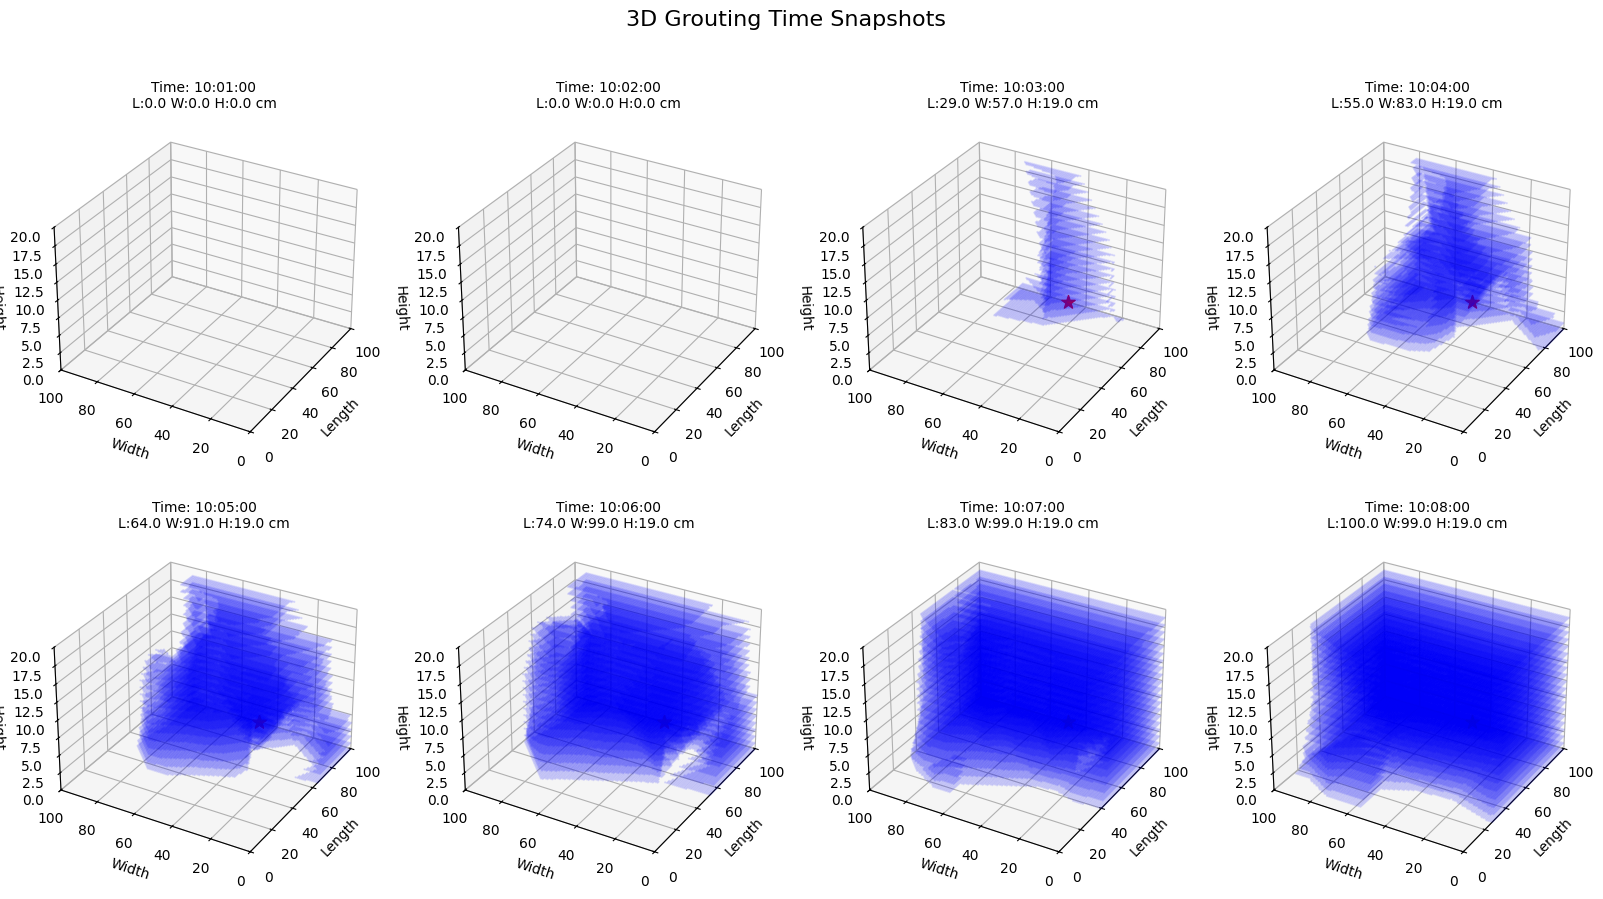

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from datetime import datetime, timedelta
import io

# ==========================================
# 1. 加载数据 (修复编码报错版)
# ==========================================
from google.colab import files
print("👇 请点击下方按钮，上传数据文件 👇")
uploaded = files.upload()

if not uploaded:
    print("❌ 未检测到文件，请重新运行。")
else:
    filename = list(uploaded.keys())[0]
    content = uploaded[filename]

    # --- 智能读取模块 ---
    df = None
    # 1. 尝试作为 Excel 读取 (防止文件其实是xlsx但后缀是csv)
    try:
        df = pd.read_excel(io.BytesIO(content))
        print("✅ 识别为 Excel 格式并读取成功")
    except:
        # 2. 尝试不同的文本编码
        encodings = ['utf-8', 'gbk', 'gb18030', 'latin1']
        for enc in encodings:
            try:
                # on_bad_lines='skip' 跳过可能的坏行
                df = pd.read_csv(io.BytesIO(content), encoding=enc, on_bad_lines='skip')
                print(f"✅ 使用 {enc} 编码读取成功")
                break
            except UnicodeDecodeError:
                continue
            except Exception as e:
                continue

    if df is None:
        print("❌ 文件读取失败！请检查文件是否损坏。")
    else:
        # ==========================================
        # 2. 数据清洗与预处理
        # ==========================================
        df.columns = df.columns.str.strip()
        col_map = {
            'Arrival_Time_s': 'Arrival_Time_s', 'Time': 'Arrival_Time_s', '时间': 'Arrival_Time_s',
            'X_cm': 'X_cm', 'X': 'X_cm', 'Y_cm': 'Y_cm', 'Y': 'Y_cm', 'Z_cm': 'Z_cm', 'Z': 'Z_cm'
        }
        df = df.rename(columns=lambda x: col_map.get(x, x))

        # 时间解析
        def parse_time(t):
            try:
                return pd.to_datetime(t, format='%H:%M:%S')
            except:
                return pd.to_datetime(t, errors='coerce')

        df['Timestamp'] = df['Arrival_Time_s'].apply(parse_time)
        valid_df = df.dropna(subset=['Timestamp']).copy()

        # 统一基准日期
        base_date = valid_df['Timestamp'].iloc[0].date()
        valid_df['Timestamp'] = valid_df['Timestamp'].apply(lambda dt: dt.replace(year=base_date.year, month=base_date.month, day=base_date.day))

        # 设定参考时间 10:00:00
        ref_time_str = "10:00:00"
        ref_time = datetime.strptime(ref_time_str, "%H:%M:%S").replace(year=base_date.year, month=base_date.month, day=base_date.day)
        valid_df['seconds_from_ref'] = (valid_df['Timestamp'] - ref_time).dt.total_seconds()

        print(f"数据加载完毕，有效数据: {len(valid_df)} 条")
        print("正在进行 3D 插值计算...")

        # ==========================================
        # 3. 3D 插值建模
        # ==========================================
        grid_step = 1.0
        grid_x, grid_y, grid_z = np.mgrid[0:100:grid_step, 0:100:grid_step, 0:20:grid_step]

        points = valid_df[['X_cm', 'Y_cm', 'Z_cm']].values
        values = valid_df['seconds_from_ref'].values

        grid_times = griddata(points, values, (grid_x, grid_y, grid_z), method='linear')
        mask = np.isnan(grid_times)
        grid_times[mask] = griddata(points, values, (grid_x[mask], grid_y[mask], grid_z[mask]), method='nearest')

        flat_x = grid_x.flatten()
        flat_y = grid_y.flatten()
        flat_z = grid_z.flatten()
        flat_t = grid_times.flatten()

        # ==========================================
        # 4. 时间切片与测量输出
        # ==========================================
        # 定义您需要的时间点
        target_times_str = [
            "10:01:00", "10:02:00", "10:03:00", "10:04:00",
            "10:05:00", "10:06:00", "10:07:00", "10:08:00",
            "10:09:00", "10:10:00", "10:11:00", "10:12:00",
        ]

        measurements = []
        fig = plt.figure(figsize=(20, 10))
        plt.suptitle('3D Grouting Time Snapshots', fontsize=16)

        for i, t_str in enumerate(target_times_str):
            target_t = datetime.strptime(t_str, "%H:%M:%S").replace(year=base_date.year, month=base_date.month, day=base_date.day)
            target_seconds = (target_t - ref_time).total_seconds()

            wet_mask = flat_t <= target_seconds

            diff_length = 0
            diff_width = 0
            diff_height = 0

            ax = fig.add_subplot(2, 4, i+1, projection='3d')

            if np.any(wet_mask):
                wet_x = flat_x[wet_mask]
                wet_y = flat_y[wet_mask]
                wet_z = flat_z[wet_mask]

                # 测量
                min_x = np.min(wet_x)
                diff_length = 100.0 - min_x

                min_y, max_y = np.min(wet_y), np.max(wet_y)
                diff_width = max_y - min_y

                max_z = np.max(wet_z)
                diff_height = max_z

                # 绘图
                ax.scatter(wet_x, wet_y, wet_z, c='blue', s=0.5, alpha=0.1)
                ax.scatter([100], [50], [0], c='red', marker='*', s=100) # 注浆口

            ax.set_title(f"Time: {t_str}\nL:{diff_length:.1f} W:{diff_width:.1f} H:{diff_height:.1f} cm", fontsize=10)
            ax.set_xlim(0, 100); ax.set_ylim(0, 100); ax.set_zlim(0, 20)
            ax.set_xlabel('Length'); ax.set_ylabel('Width'); ax.set_zlabel('Height')
            ax.view_init(elev=30, azim=210)

            measurements.append({
                "Time": t_str,
                "Length_Diffusion_cm": round(diff_length, 2),
                "Width_Diffusion_cm": round(diff_width, 2),
                "Height_Diffusion_cm": round(diff_height, 2)
            })

        plt.tight_layout()
        plt.subplots_adjust(top=0.90)
        plt.show()

        # 输出表格
        meas_df = pd.DataFrame(measurements)
        print("\n========== 浆液扩散测量结果 ==========")
        print(meas_df)
        meas_df.to_csv('diffusion_measurements.csv', index=False)
        print("\n结果已保存为 diffusion_measurements.csv")

👇 请点击下方按钮，上传数据文件 👇


Saving grouting_final.csv.xlsx to grouting_final.csv (3).xlsx
✅ 识别为 Excel 格式并读取成功
数据加载完毕，有效数据: 75 条
正在进行 3D 插值计算...


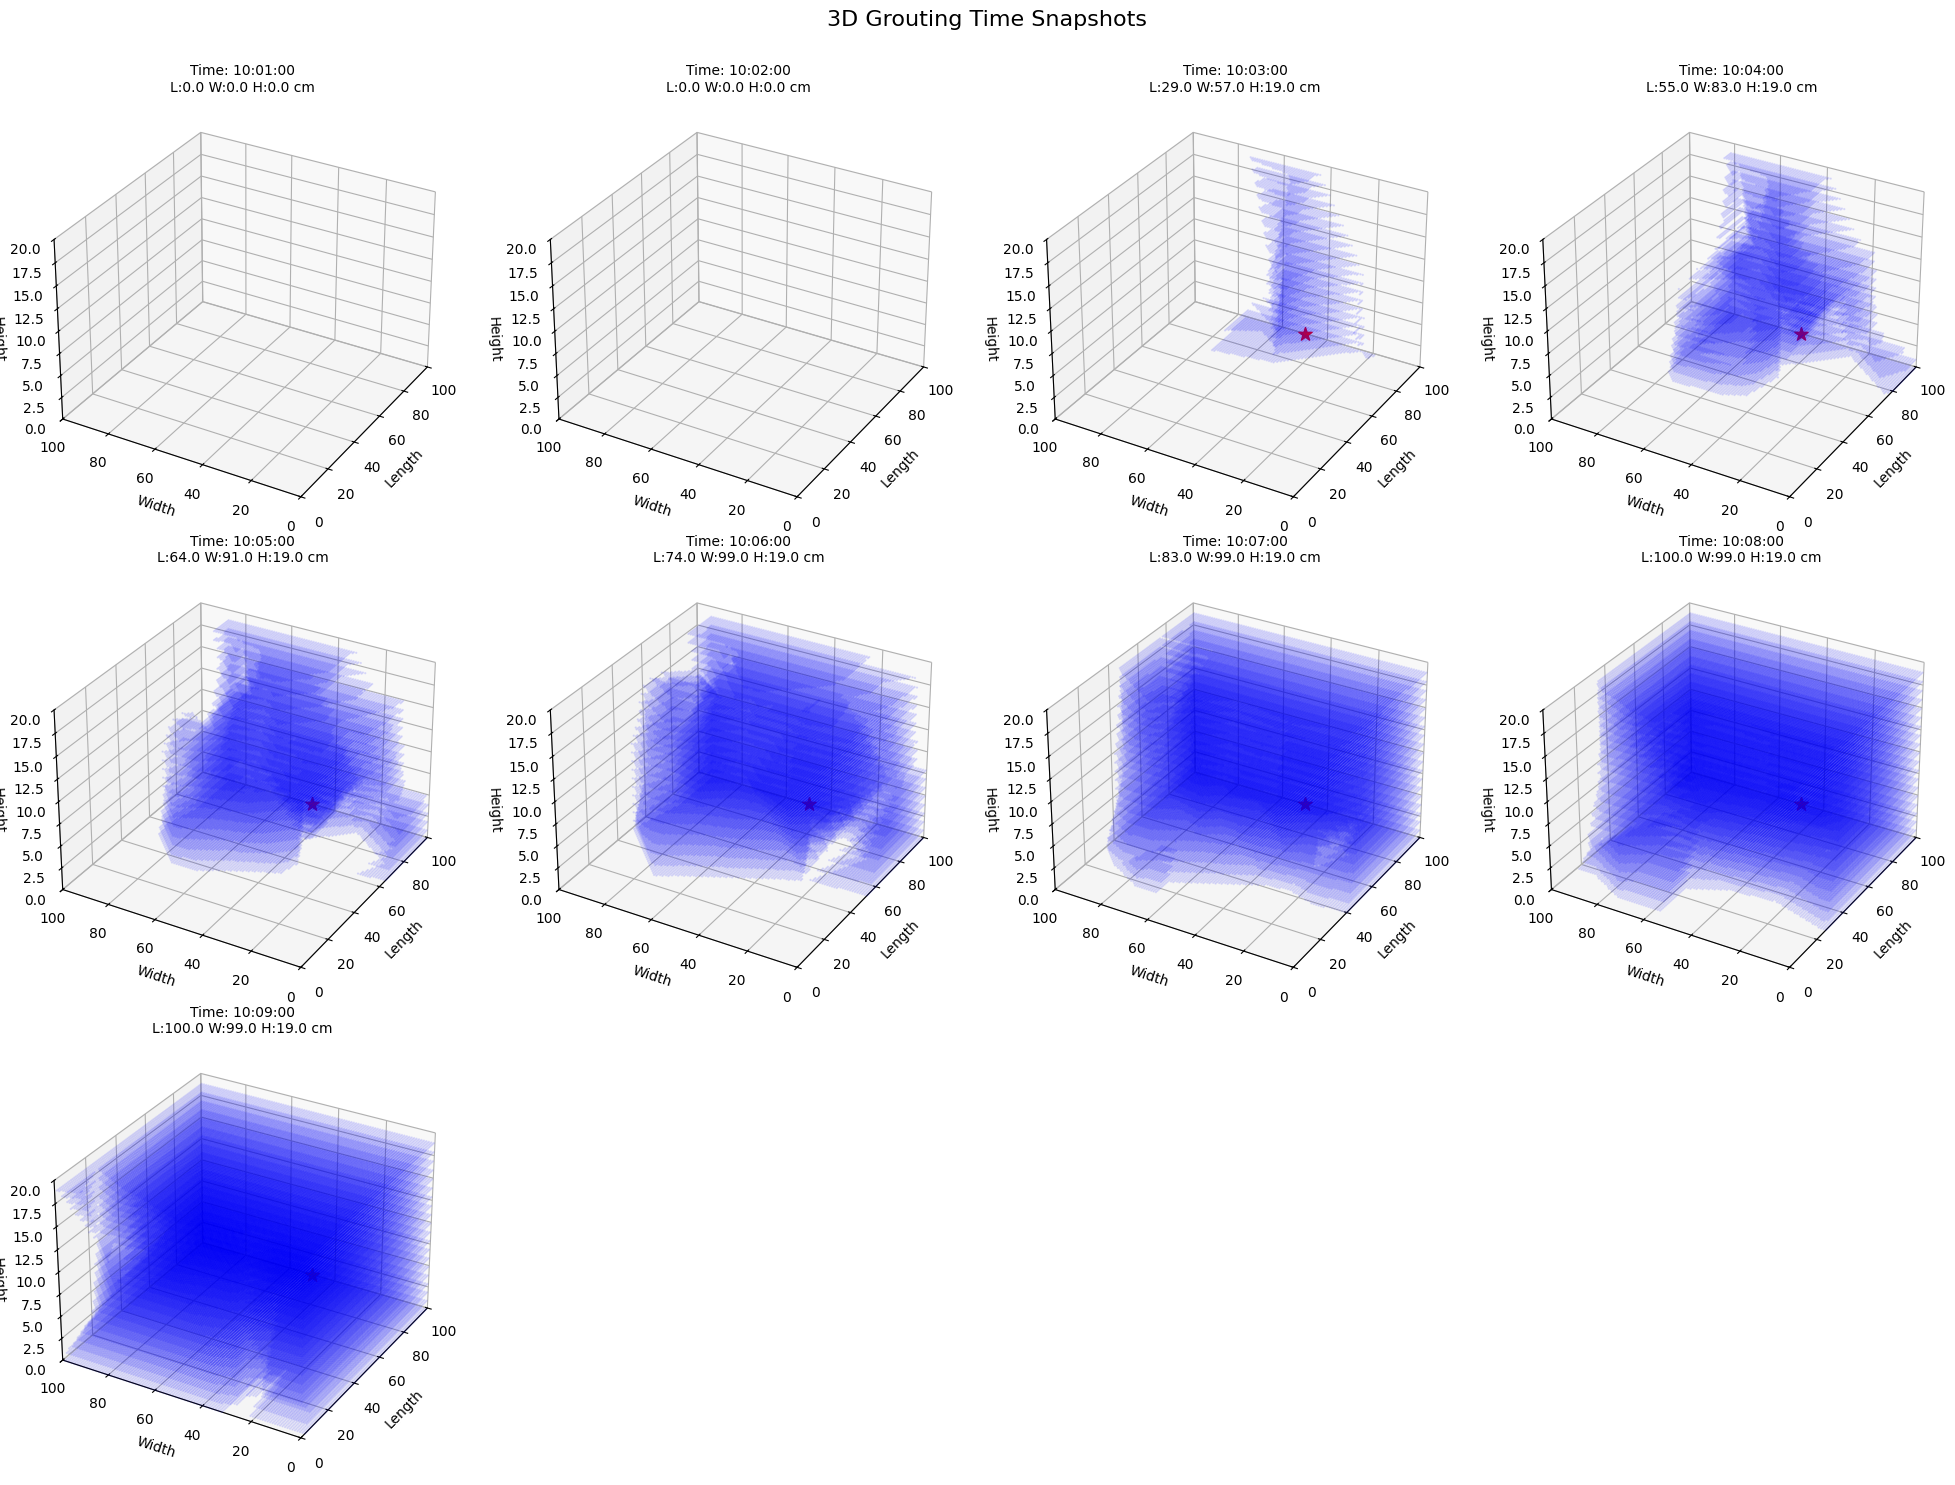


========== 浆液扩散测量结果 ==========
       Time  Length_Diffusion_cm  Width_Diffusion_cm  Height_Diffusion_cm
0  10:01:00                  0.0                 0.0                  0.0
1  10:02:00                  0.0                 0.0                  0.0
2  10:03:00                 29.0                57.0                 19.0
3  10:04:00                 55.0                83.0                 19.0
4  10:05:00                 64.0                91.0                 19.0
5  10:06:00                 74.0                99.0                 19.0
6  10:07:00                 83.0                99.0                 19.0
7  10:08:00                100.0                99.0                 19.0
8  10:09:00                100.0                99.0                 19.0

结果已保存为 diffusion_measurements.csv


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from datetime import datetime, timedelta
import io

# ==========================================
# 1. 加载数据 (智能修复版)
# ==========================================
from google.colab import files
print("👇 请点击下方按钮，上传数据文件 👇")
uploaded = files.upload()

if not uploaded:
    print("❌ 未检测到文件，请重新运行。")
else:
    filename = list(uploaded.keys())[0]
    content = uploaded[filename]

    # --- 智能读取模块 ---
    df = None
    # 1. 尝试作为 Excel 读取
    try:
        df = pd.read_excel(io.BytesIO(content))
        print("✅ 识别为 Excel 格式并读取成功")
    except:
        # 2. 尝试不同的文本编码
        encodings = ['utf-8', 'gbk', 'gb18030', 'latin1']
        for enc in encodings:
            try:
                # on_bad_lines='skip' 跳过可能的坏行
                df = pd.read_csv(io.BytesIO(content), encoding=enc, on_bad_lines='skip')
                print(f"✅ 使用 {enc} 编码读取成功")
                break
            except Exception:
                continue

    if df is None:
        print("❌ 文件读取失败！请检查文件是否损坏。")
    else:
        # ==========================================
        # 2. 数据清洗与预处理
        # ==========================================
        df.columns = df.columns.str.strip()
        col_map = {
            'Arrival_Time_s': 'Arrival_Time_s', 'Time': 'Arrival_Time_s', '时间': 'Arrival_Time_s',
            'X_cm': 'X_cm', 'X': 'X_cm', 'Y_cm': 'Y_cm', 'Y': 'Y_cm', 'Z_cm': 'Z_cm', 'Z': 'Z_cm'
        }
        df = df.rename(columns=lambda x: col_map.get(x, x))

        # 时间解析
        def parse_time(t):
            try:
                return pd.to_datetime(t, format='%H:%M:%S')
            except:
                return pd.to_datetime(t, errors='coerce')

        df['Timestamp'] = df['Arrival_Time_s'].apply(parse_time)
        valid_df = df.dropna(subset=['Timestamp']).copy()

        # 统一基准日期
        base_date = valid_df['Timestamp'].iloc[0].date()
        valid_df['Timestamp'] = valid_df['Timestamp'].apply(lambda dt: dt.replace(year=base_date.year, month=base_date.month, day=base_date.day))

        # 设定参考时间 10:00:00
        ref_time_str = "10:00:00"
        ref_time = datetime.strptime(ref_time_str, "%H:%M:%S").replace(year=base_date.year, month=base_date.month, day=base_date.day)
        valid_df['seconds_from_ref'] = (valid_df['Timestamp'] - ref_time).dt.total_seconds()

        print(f"数据加载完毕，有效数据: {len(valid_df)} 条")
        print("正在进行 3D 插值计算...")

        # ==========================================
        # 3. 3D 插值建模
        # ==========================================
        grid_step = 1.0
        grid_x, grid_y, grid_z = np.mgrid[0:100:grid_step, 0:100:grid_step, 0:20:grid_step]

        points = valid_df[['X_cm', 'Y_cm', 'Z_cm']].values
        values = valid_df['seconds_from_ref'].values

        # 线性插值
        grid_times = griddata(points, values, (grid_x, grid_y, grid_z), method='linear')
        # 边缘填充
        mask = np.isnan(grid_times)
        grid_times[mask] = griddata(points, values, (grid_x[mask], grid_y[mask], grid_z[mask]), method='nearest')

        flat_x = grid_x.flatten()
        flat_y = grid_y.flatten()
        flat_z = grid_z.flatten()
        flat_t = grid_times.flatten()

        # ==========================================
        # 4. 时间切片与测量输出 (已修复逗号问题)
        # ==========================================
        target_times_str = [
            "10:01:00", "10:02:00", "10:03:00", "10:04:00",
            "10:05:00", "10:06:00", "10:07:00", "10:08:00",
            "10:09:00"  # 确保这里及上一行末尾都有逗号
        ]

        measurements = []
        # 根据时间点数量自动调整画布行数 (每行4个)
        num_plots = len(target_times_str)
        rows = (num_plots + 3) // 4
        fig = plt.figure(figsize=(20, 5 * rows))

        plt.suptitle('3D Grouting Time Snapshots', fontsize=16)

        for i, t_str in enumerate(target_times_str):
            target_t = datetime.strptime(t_str, "%H:%M:%S").replace(year=base_date.year, month=base_date.month, day=base_date.day)
            target_seconds = (target_t - ref_time).total_seconds()

            wet_mask = flat_t <= target_seconds

            diff_length = 0
            diff_width = 0
            diff_height = 0

            ax = fig.add_subplot(rows, 4, i+1, projection='3d')

            if np.any(wet_mask):
                wet_x = flat_x[wet_mask]
                wet_y = flat_y[wet_mask]
                wet_z = flat_z[wet_mask]

                # 测量
                min_x = np.min(wet_x)
                diff_length = 100.0 - min_x

                min_y, max_y = np.min(wet_y), np.max(wet_y)
                diff_width = max_y - min_y

                max_z = np.max(wet_z)
                diff_height = max_z

                # 绘图
                ax.scatter(wet_x, wet_y, wet_z, c='blue', s=0.5, alpha=0.1)
                ax.scatter([100], [50], [0], c='red', marker='*', s=100) # 注浆口

            ax.set_title(f"Time: {t_str}\nL:{diff_length:.1f} W:{diff_width:.1f} H:{diff_height:.1f} cm", fontsize=10)
            ax.set_xlim(0, 100); ax.set_ylim(0, 100); ax.set_zlim(0, 20)
            ax.set_xlabel('Length'); ax.set_ylabel('Width'); ax.set_zlabel('Height')
            ax.view_init(elev=30, azim=210)

            measurements.append({
                "Time": t_str,
                "Length_Diffusion_cm": round(diff_length, 2),
                "Width_Diffusion_cm": round(diff_width, 2),
                "Height_Diffusion_cm": round(diff_height, 2)
            })

        plt.tight_layout()
        plt.subplots_adjust(top=0.92)
        plt.show()

        # 输出表格
        meas_df = pd.DataFrame(measurements)
        print("\n========== 浆液扩散测量结果 ==========")
        print(meas_df)
        meas_df.to_csv('diffusion_measurements.csv', index=False)
        print("\n结果已保存为 diffusion_measurements.csv")

👇 请点击下方按钮，上传数据文件 👇


Saving grouting_final.csv.xlsx to grouting_final.csv (4).xlsx
数据加载成功。有效点数: 75
设定注浆时间: 10:00:30 至 10:12:30
正在利用插值法构建 3D 浆液模型...


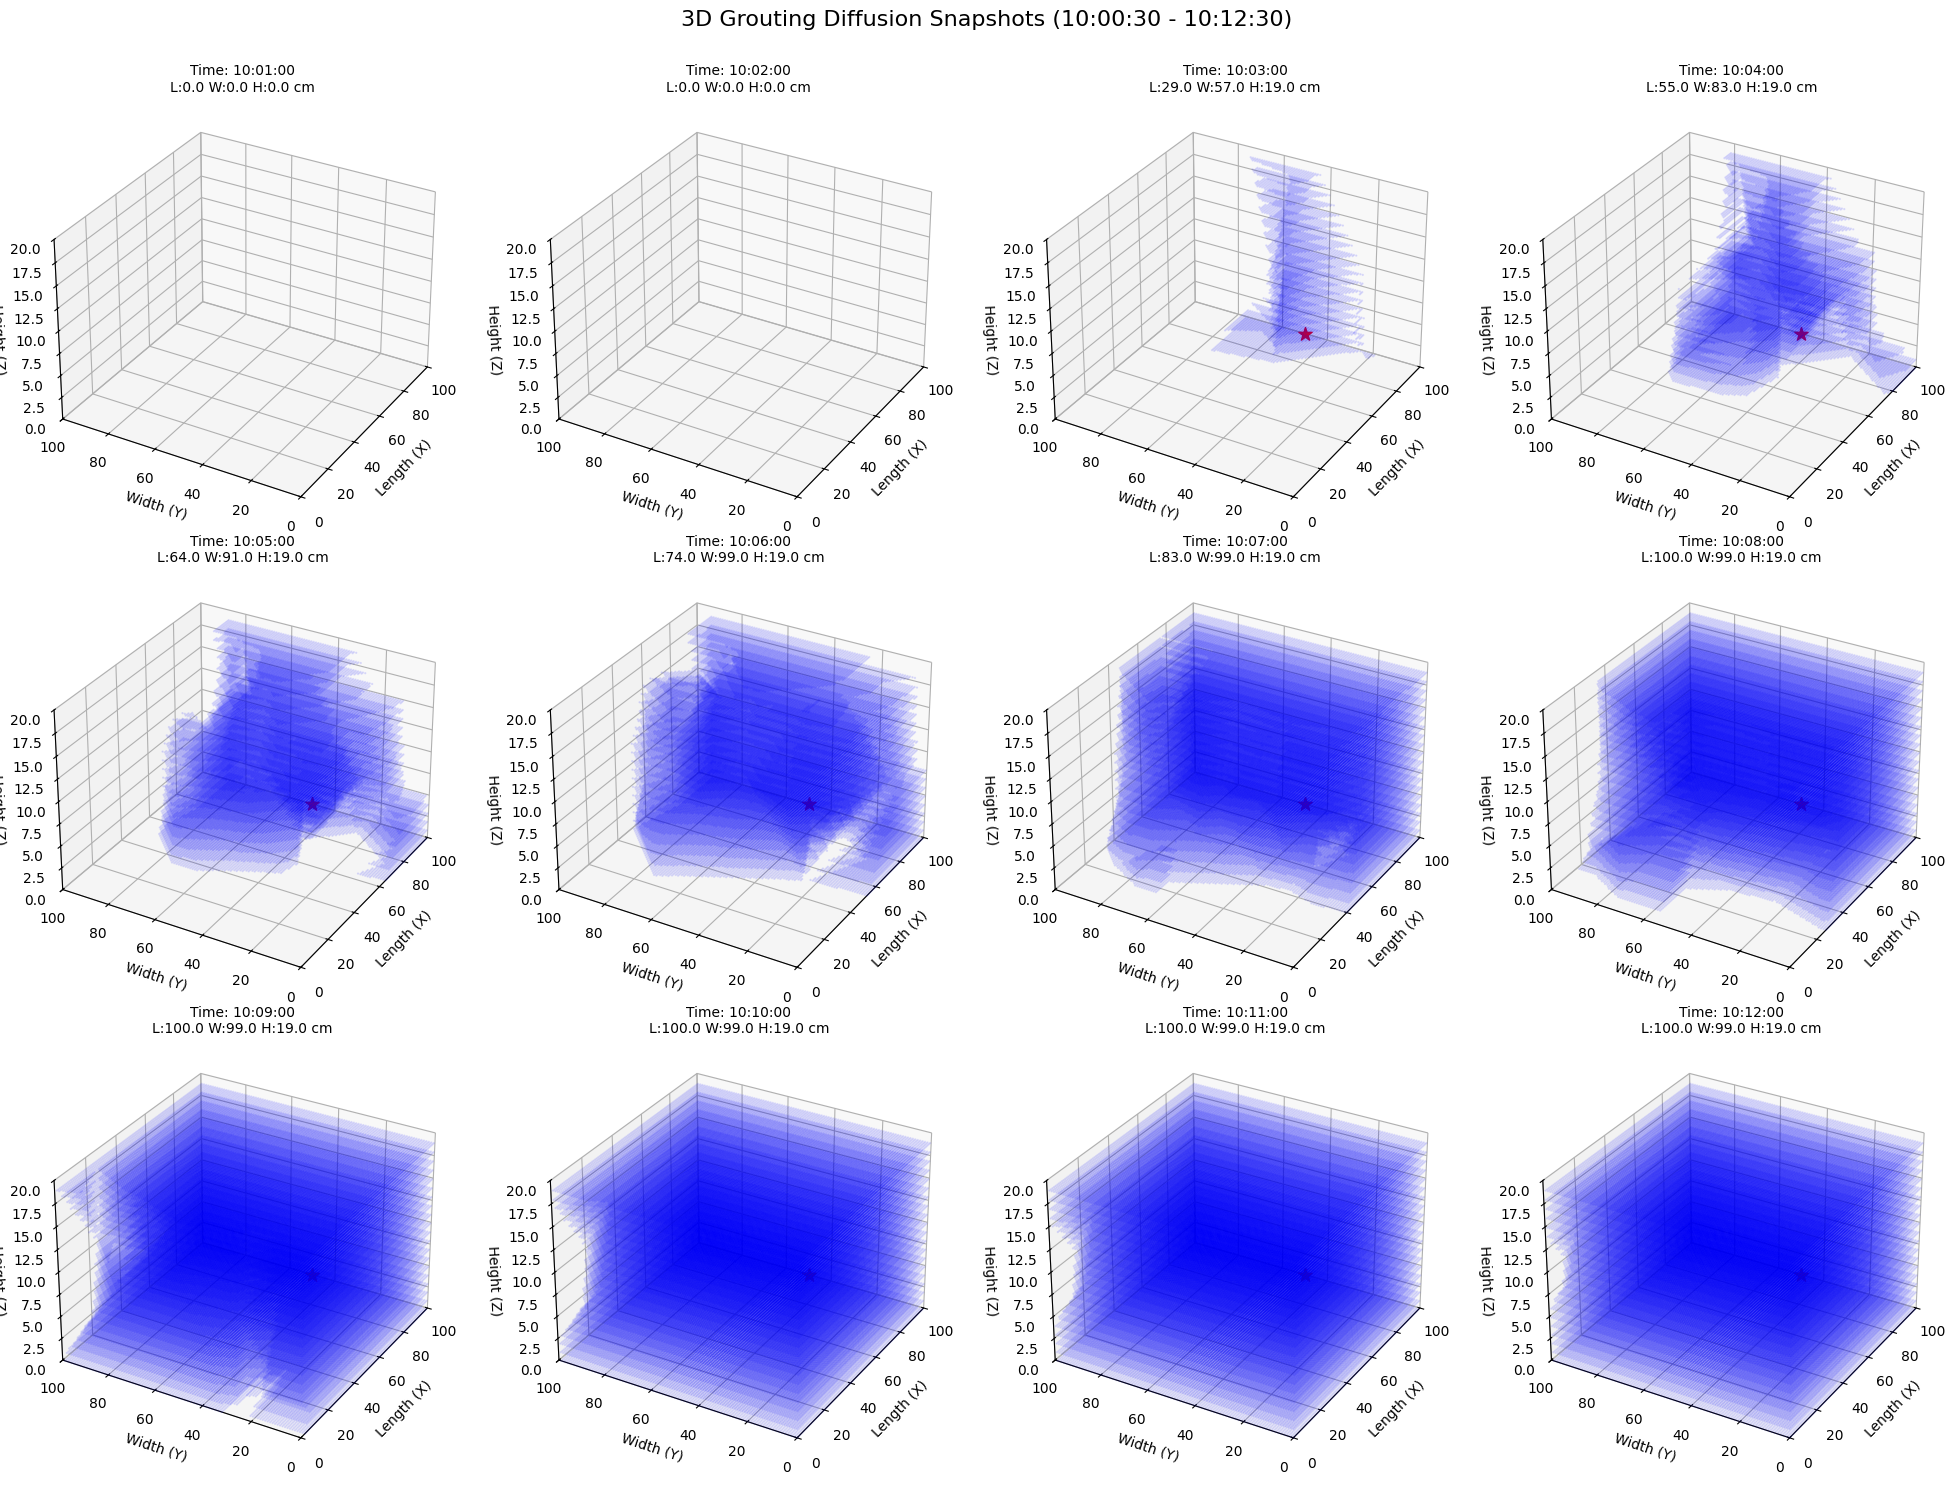


========== 浆液扩散测量结果 ==========
        Time  Length_Diffusion_cm  Width_Diffusion_cm  Height_Diffusion_cm
0   10:01:00                  0.0                 0.0                  0.0
1   10:02:00                  0.0                 0.0                  0.0
2   10:03:00                 29.0                57.0                 19.0
3   10:04:00                 55.0                83.0                 19.0
4   10:05:00                 64.0                91.0                 19.0
5   10:06:00                 74.0                99.0                 19.0
6   10:07:00                 83.0                99.0                 19.0
7   10:08:00                100.0                99.0                 19.0
8   10:09:00                100.0                99.0                 19.0
9   10:10:00                100.0                99.0                 19.0
10  10:11:00                100.0                99.0                 19.0
11  10:12:00                100.0                99.0               

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from datetime import datetime, timedelta
import io

# ==========================================
# 1. 加载数据 (智能修复版)
# ==========================================
# 如果您在 Google Colab，请取消下面两行的注释来上传文件
from google.colab import files
print("👇 请点击下方按钮，上传数据文件 👇")
uploaded = files.upload()

if not uploaded:
    print("❌ 未检测到文件，请重新运行。")
else:
    filename = list(uploaded.keys())[0]
    content = uploaded[filename]

    # 智能读取 (兼容 Excel 和 CSV 及不同编码)
    def load_data_robust(content):
        try:
            return pd.read_excel(io.BytesIO(content))
        except:
            pass
        for enc in ['utf-8', 'gbk', 'gb18030', 'latin1']:
            try:
                return pd.read_csv(io.BytesIO(content), encoding=enc, on_bad_lines='skip')
            except:
                continue
        return None

    df = load_data_robust(content)

    if df is None:
        print("❌ 文件读取失败！请检查文件格式。")
    else:
        # ==========================================
        # 2. 数据清洗与时间设定
        # ==========================================
        # 清洗列名
        df.columns = df.columns.str.strip()
        col_map = {
            'Arrival_Time_s': 'Arrival_Time_s', 'Time': 'Arrival_Time_s', '时间': 'Arrival_Time_s',
            'X_cm': 'X_cm', 'X': 'X_cm', 'Y_cm': 'Y_cm', 'Y': 'Y_cm', 'Z_cm': 'Z_cm', 'Z': 'Z_cm'
        }
        df = df.rename(columns=lambda x: col_map.get(x, x))

        # 解析时间
        def parse_time(t):
            try:
                return pd.to_datetime(t, format='%H:%M:%S')
            except:
                return pd.to_datetime(t, errors='coerce')

        df['Timestamp'] = df['Arrival_Time_s'].apply(parse_time)
        valid_df = df.dropna(subset=['Timestamp']).copy()

        # 统一日期基准 (处理 1900-01-01)
        base_date = valid_df['Timestamp'].iloc[0].date()
        valid_df['Timestamp'] = valid_df['Timestamp'].apply(
            lambda dt: dt.replace(year=base_date.year, month=base_date.month, day=base_date.day)
        )

        # --- 设置实验起止时间 ---
        start_time_str = "10:00:30"
        end_time_str = "10:12:30"

        start_time = datetime.strptime(start_time_str, "%H:%M:%S").replace(
            year=base_date.year, month=base_date.month, day=base_date.day
        )
        end_time = datetime.strptime(end_time_str, "%H:%M:%S").replace(
            year=base_date.year, month=base_date.month, day=base_date.day
        )

        # 计算相对秒数 (用于插值，值为相对于 10:00:30 的秒数)
        valid_df['seconds_from_start'] = (valid_df['Timestamp'] - start_time).dt.total_seconds()

        print(f"数据加载成功。有效点数: {len(valid_df)}")
        print(f"设定注浆时间: {start_time_str} 至 {end_time_str}")
        print("正在利用插值法构建 3D 浆液模型...")

        # ==========================================
        # 3. 空间插值 (Grid Interpolation)
        # ==========================================
        # 建立 100x100x20 的网格
        grid_step = 1.0 # 网格间距 1cm
        grid_x, grid_y, grid_z = np.mgrid[0:100:grid_step, 0:100:grid_step, 0:20:grid_step]

        points = valid_df[['X_cm', 'Y_cm', 'Z_cm']].values
        values = valid_df['seconds_from_start'].values

        # 线性插值 (Linear)
        grid_times = griddata(points, values, (grid_x, grid_y, grid_z), method='linear')

        # 边缘填充 (Nearest Neighbor) - 防止最外层出现空洞
        mask = np.isnan(grid_times)
        grid_times[mask] = griddata(points, values, (grid_x[mask], grid_y[mask], grid_z[mask]), method='nearest')

        flat_x = grid_x.flatten()
        flat_y = grid_y.flatten()
        flat_z = grid_z.flatten()
        flat_t = grid_times.flatten()

        # ==========================================
        # 4. 生成时间切片 & 自动测量
        # ==========================================
        # 生成时间点列表: 从 10:01:00 开始, 每分钟一个, 直到 10:12:00
        target_times = []
        current_t = start_time.replace(second=0) + timedelta(minutes=1) # 从下一整分钟开始 (10:01:00)

        while current_t <= end_time:
            if current_t > start_time:
                target_times.append(current_t)
            current_t += timedelta(minutes=1)

        measurements = []

        # 绘图布局计算
        num_plots = len(target_times)
        cols = 4
        rows = (num_plots + cols - 1) // cols
        fig = plt.figure(figsize=(20, 5 * rows))
        plt.suptitle(f'3D Grouting Diffusion Snapshots ({start_time_str} - {end_time_str})', fontsize=16)

        for i, target_t in enumerate(target_times):
            # 计算当前目标时间相对于 StartTime (10:00:30) 的秒数
            target_seconds = (target_t - start_time).total_seconds()

            # 核心逻辑: 只有当 grid_time <= target_seconds 时，该点才被视为“已变湿”
            wet_mask = flat_t <= target_seconds

            diff_length = 0
            diff_width = 0
            diff_height = 0

            ax = fig.add_subplot(rows, cols, i+1, projection='3d')

            if np.any(wet_mask):
                wet_x = flat_x[wet_mask]
                wet_y = flat_y[wet_mask]
                wet_z = flat_z[wet_mask]

                # --- 测量扩散距离 ---
                # 假设注浆源位于 X=100
                # 长向 (Length): 100 - X_min (向前推进距离)
                min_x = np.min(wet_x)
                diff_length = 100.0 - min_x

                # 宽向 (Width): Y_max - Y_min (横向覆盖宽度)
                min_y, max_y = np.min(wet_y), np.max(wet_y)
                diff_width = max_y - min_y

                # 高向 (Height): Z_max (爬升高度)
                max_z = np.max(wet_z)
                diff_height = max_z

                # 绘制浆液粒子
                ax.scatter(wet_x, wet_y, wet_z, c='blue', s=0.5, alpha=0.1)
                # 标记注浆源
                ax.scatter([100], [50], [0], c='red', marker='*', s=100)

            t_str = target_t.strftime("%H:%M:%S")
            ax.set_title(f"Time: {t_str}\nL:{diff_length:.1f} W:{diff_width:.1f} H:{diff_height:.1f} cm", fontsize=10)

            ax.set_xlim(0, 100); ax.set_ylim(0, 100); ax.set_zlim(0, 20)
            ax.set_xlabel('Length (X)'); ax.set_ylabel('Width (Y)'); ax.set_zlabel('Height (Z)')
            ax.view_init(elev=30, azim=210)

            measurements.append({
                "Time": t_str,
                "Length_Diffusion_cm": round(diff_length, 2),
                "Width_Diffusion_cm": round(diff_width, 2),
                "Height_Diffusion_cm": round(diff_height, 2)
            })

        plt.tight_layout()
        plt.subplots_adjust(top=0.92)
        plt.show()

        # 输出并保存结果
        meas_df = pd.DataFrame(measurements)
        print("\n========== 浆液扩散测量结果 ==========")
        print(meas_df)
        meas_df.to_csv('grouting_measurements_interpolated.csv', index=False)
        print("\n结果已保存为 'grouting_measurements_interpolated.csv'")

👇 请点击下方按钮，上传数据文件 (grouting_final.csv) 👇


Saving grouting_final.csv.xlsx to grouting_final.csv (5).xlsx
数据加载成功。有效点数: 75
设定注浆时间范围: 10:00:30 至 10:12:30
正在进行全方位(X, Y, Z)插值计算...


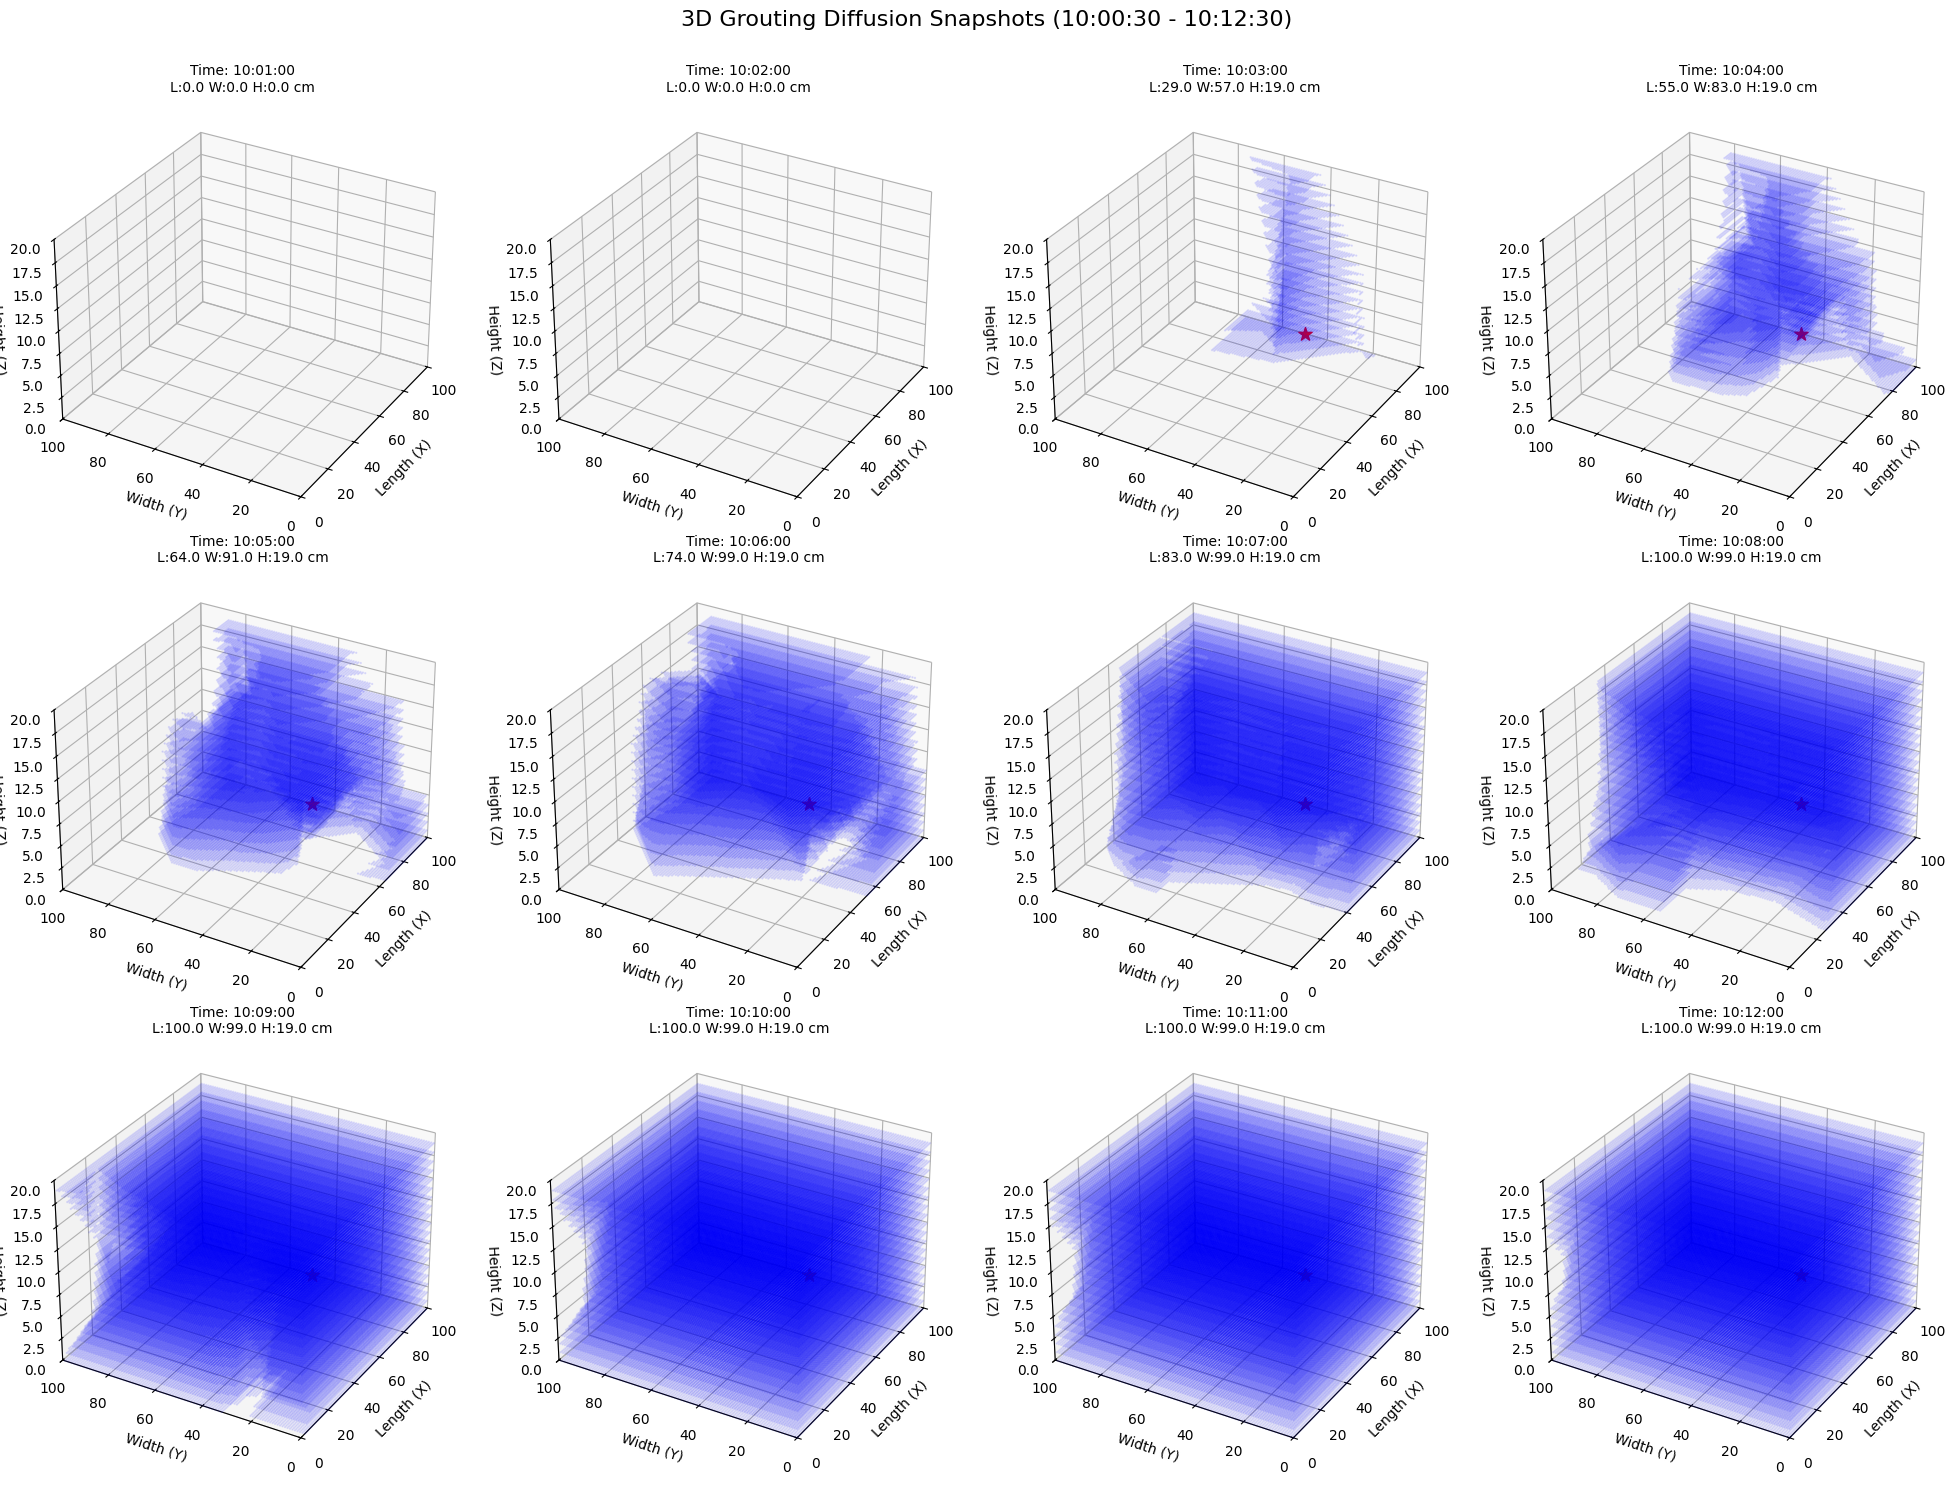


========== 插值后测量结果 (Y方向已加密) ==========
        Time  Length_Diffusion_cm  Width_Diffusion_cm  Height_Diffusion_cm
0   10:01:00                  0.0                 0.0                  0.0
1   10:02:00                  0.0                 0.0                  0.0
2   10:03:00                 29.0                57.0                 19.0
3   10:04:00                 55.0                83.0                 19.0
4   10:05:00                 64.0                91.0                 19.0
5   10:06:00                 74.0                99.0                 19.0
6   10:07:00                 83.0                99.0                 19.0
7   10:08:00                100.0                99.0                 19.0
8   10:09:00                100.0                99.0                 19.0
9   10:10:00                100.0                99.0                 19.0
10  10:11:00                100.0                99.0                 19.0
11  10:12:00                100.0                99.0       

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from datetime import datetime, timedelta
import io

# ==========================================
# 1. 加载数据 (支持本地或Colab上传)
# ==========================================
# 如果您在 Google Colab，请取消下面两行的注释来上传文件
from google.colab import files
print("👇 请点击下方按钮，上传数据文件 (grouting_final.csv) 👇")
uploaded = files.upload()

if not uploaded:
    print("❌ 未检测到文件，请重新运行。")
else:
    filename = list(uploaded.keys())[0]
    content = uploaded[filename]

    # 智能读取函数
    def load_data_robust(content):
        # 优先尝试 Excel
        try:
            return pd.read_excel(io.BytesIO(content))
        except:
            pass
        # 尝试 CSV 的各种编码
        for enc in ['utf-8', 'gbk', 'gb18030', 'latin1']:
            try:
                return pd.read_csv(io.BytesIO(content), encoding=enc, on_bad_lines='skip')
            except:
                continue
        return None

    df = load_data_robust(content)

    if df is None:
        print("❌ 文件读取失败，请检查格式。")
    else:
        # ==========================================
        # 2. 数据清洗与时间设定
        # ==========================================
        df.columns = df.columns.str.strip()
        col_map = {
            'Arrival_Time_s': 'Arrival_Time_s', 'Time': 'Arrival_Time_s', '时间': 'Arrival_Time_s',
            'X_cm': 'X_cm', 'X': 'X_cm', 'Y_cm': 'Y_cm', 'Y': 'Y_cm', 'Z_cm': 'Z_cm', 'Z': 'Z_cm'
        }
        df = df.rename(columns=lambda x: col_map.get(x, x))

        # 解析时间
        def parse_time(t):
            try:
                return pd.to_datetime(t, format='%H:%M:%S')
            except:
                return pd.to_datetime(t, errors='coerce')

        df['Timestamp'] = df['Arrival_Time_s'].apply(parse_time)
        valid_df = df.dropna(subset=['Timestamp']).copy()

        # 统一基准日期
        base_date = valid_df['Timestamp'].iloc[0].date()
        valid_df['Timestamp'] = valid_df['Timestamp'].apply(
            lambda dt: dt.replace(year=base_date.year, month=base_date.month, day=base_date.day)
        )

        # --- 设定注浆起止时间 ---
        start_time_str = "10:00:30"
        end_time_str = "10:12:30"

        start_time = datetime.strptime(start_time_str, "%H:%M:%S").replace(
            year=base_date.year, month=base_date.month, day=base_date.day
        )
        end_time = datetime.strptime(end_time_str, "%H:%M:%S").replace(
            year=base_date.year, month=base_date.month, day=base_date.day
        )

        # 计算相对秒数 (以 StartTime 为 0)
        valid_df['seconds_from_start'] = (valid_df['Timestamp'] - start_time).dt.total_seconds()

        print(f"数据加载成功。有效点数: {len(valid_df)}")
        print(f"设定注浆时间范围: {start_time_str} 至 {end_time_str}")
        print("正在进行全方位(X, Y, Z)插值计算...")

        # ==========================================
        # 3. 3D全向插值 (包含 Y 方向的精细插值)
        # ==========================================
        # 设定网格精度为 1.0cm
        # 这意味着在 Y 方向上，我们会生成 0, 1, 2, ..., 100cm 的所有点
        # 从而填补传感器之间(例如 25cm 到 50cm 之间) 的空白
        grid_step = 1.0
        grid_x, grid_y, grid_z = np.mgrid[0:100:grid_step, 0:100:grid_step, 0:20:grid_step]

        points = valid_df[['X_cm', 'Y_cm', 'Z_cm']].values
        values = valid_df['seconds_from_start'].values

        # 核心插值函数：griddata
        # method='linear' 会在 X, Y, Z 三个方向上构建线性过渡
        grid_times = griddata(points, values, (grid_x, grid_y, grid_z), method='linear')

        # 边缘填充 (防止最外圈为空)
        mask = np.isnan(grid_times)
        grid_times[mask] = griddata(points, values, (grid_x[mask], grid_y[mask], grid_z[mask]), method='nearest')

        flat_x = grid_x.flatten()
        flat_y = grid_y.flatten()
        flat_z = grid_z.flatten()
        flat_t = grid_times.flatten()

        # ==========================================
        # 4. 生成时间切片 & 测量
        # ==========================================
        # 生成时间列表: 从 10:01:00 开始, 直到 10:12:00
        target_times = []
        # 从开始时间后的下一个整分开始
        current_t = start_time + timedelta(seconds=60 - start_time.second if start_time.second > 0 else 0)
        if current_t <= start_time: current_t += timedelta(minutes=1) # 确保往后

        # 或者简单粗暴：10:01, 10:02...
        t_cursor = datetime.strptime("10:01:00", "%H:%M:%S").replace(year=base_date.year, month=base_date.month, day=base_date.day)

        while t_cursor <= end_time:
            if t_cursor > start_time:
                target_times.append(t_cursor)
            t_cursor += timedelta(minutes=1)

        measurements = []

        # 绘图设置
        num_plots = len(target_times)
        cols = 4
        rows = (num_plots + cols - 1) // cols
        fig = plt.figure(figsize=(20, 5 * rows))
        plt.suptitle(f'3D Grouting Diffusion Snapshots ({start_time_str} - {end_time_str})', fontsize=16)

        for i, target_t in enumerate(target_times):
            # 计算目标时刻对应的秒数
            target_seconds = (target_t - start_time).total_seconds()

            # 筛选出当前时刻已变湿的网格点
            # 这里的 flat_y 已经是经过 1cm 插值加密后的 Y 坐标
            wet_mask = flat_t <= target_seconds

            diff_length = 0
            diff_width = 0
            diff_height = 0

            ax = fig.add_subplot(rows, cols, i+1, projection='3d')

            if np.any(wet_mask):
                wet_x = flat_x[wet_mask]
                wet_y = flat_y[wet_mask]
                wet_z = flat_z[wet_mask]

                # --- 测量计算 (基于插值后的密集网格) ---
                # 1. 长向 (Length): 注浆口 X=100 -> 向 X=0 推进
                min_x = np.min(wet_x)
                diff_length = 100.0 - min_x

                # 2. 宽向 (Width): Y方向的最大跨度
                # 由于进行了 Y 方向插值，这里的 max_y - min_y 能够精确到 1cm
                min_y, max_y = np.min(wet_y), np.max(wet_y)
                diff_width = max_y - min_y

                # 3. 高向 (Height)
                max_z = np.max(wet_z)
                diff_height = max_z

                # 绘图
                ax.scatter(wet_x, wet_y, wet_z, c='blue', s=0.5, alpha=0.1)
                ax.scatter([100], [50], [0], c='red', marker='*', s=100) # 标记注浆源

            t_str = target_t.strftime("%H:%M:%S")
            ax.set_title(f"Time: {t_str}\nL:{diff_length:.1f} W:{diff_width:.1f} H:{diff_height:.1f} cm", fontsize=10)

            ax.set_xlim(0, 100); ax.set_ylim(0, 100); ax.set_zlim(0, 20)
            ax.set_xlabel('Length (X)'); ax.set_ylabel('Width (Y)'); ax.set_zlabel('Height (Z)')
            ax.view_init(elev=30, azim=210)

            measurements.append({
                "Time": t_str,
                "Length_Diffusion_cm": round(diff_length, 2),
                "Width_Diffusion_cm": round(diff_width, 2),
                "Height_Diffusion_cm": round(diff_height, 2)
            })

        plt.tight_layout()
        plt.subplots_adjust(top=0.92)
        plt.show()

        # 保存结果
        meas_df = pd.DataFrame(measurements)
        print("\n========== 插值后测量结果 (Y方向已加密) ==========")
        print(meas_df)
        meas_df.to_csv('grouting_measurements_interpolated_Y.csv', index=False)
        print("\n结果已保存为 'grouting_measurements_interpolated_Y.csv'")